## Import the libraries

In [115]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_recall_fscore_support
)

## Load dataset

In [116]:
dataset = load_dataset("meriemm6/commit-classification-dataset")
dataset


DatasetDict({
    train: Dataset({
        features: ['id', 'Commit Hash', 'Subject', 'Message', 'Old Contents', 'New Contents', 'Ground truth'],
        num_rows: 1436
    })
    validation: Dataset({
        features: ['id', 'Commit Hash', 'Subject', 'Message', 'Old Contents', 'New Contents', 'Ground truth'],
        num_rows: 306
    })
    test: Dataset({
        features: ['id', 'Commit Hash', 'Subject', 'Message', 'Old Contents', 'New Contents', 'Ground truth'],
        num_rows: 206
    })
})

## Dataset Splits, Column Names and Size

In [117]:
for split in dataset.keys():
    print(f" * {split}: {len(dataset[split])} rows")
    print(f"   Columns: {dataset[split].column_names}")

 * train: 1436 rows
   Columns: ['id', 'Commit Hash', 'Subject', 'Message', 'Old Contents', 'New Contents', 'Ground truth']
 * validation: 306 rows
   Columns: ['id', 'Commit Hash', 'Subject', 'Message', 'Old Contents', 'New Contents', 'Ground truth']
 * test: 206 rows
   Columns: ['id', 'Commit Hash', 'Subject', 'Message', 'Old Contents', 'New Contents', 'Ground truth']


## Training Data

In [118]:
train_df = pd.DataFrame(dataset['train'])
train_df

,id,Commit Hash,Subject,Message,Old Contents,New Contents,Ground truth
0,262,fd2247cbcee7415a6703cc9221d53f5dbac9accc,Bumped source to 20211130-4c00e06,Bumped source to 20211130-4c00e06\n,FROM docker.pkg.github.com/dock0/arch/arch:202...,FROM docker.pkg.github.com/dock0/arch/arch:202...,maintenance/other
1,2103,d7d82169d11383f225a46cfa76cacb9a993c4135,Bumped source to 20210629-6b7f787,Bumped source to 20210629-6b7f787\n,FROM docker.pkg.github.com/dock0/arch/arch:202...,None,maintenance/other
2,374,90bde9493ac67b6683c885859581cf52f73b489e,Bumped source to 20201103-c055246,Bumped source to 20201103-c055246\n,FROM docker.pkg.github.com/dock0/amylum_arch/a...,FROM docker.pkg.github.com/dock0/amylum_arch/a...,maintenance/other
3,2310,439ce8e0e4d322ae7d9e702ce1ac38becaacdeb7,Update Dockerfile,Update Dockerfile\n\nkeeping bash.,FROM centos:7.3.1611\n\nMAINTAINER Robert de B...,None,code refactoring
4,2170,3573db30cf61da7cbc7eee0a5234d286576f5665,add gnu tar for mesos docker fetcher,add gnu tar for mesos docker fetcher\n,FROM quay.io/vektorcloud/base:3.4\n\nRUN apk -...,None,feature addition
...,...,...,...,...,...,...,...
1431,77,None,None,None,None,None,maintenance/other
1432,2230,None,None,None,None,None,code refactoring
1433,41,None,None,None,None,None,code refactoring
1434,328,None,None,None,None,None,code refactoring


## Testing Data

In [119]:
testing_df = pd.DataFrame(dataset['test'])
testing_df

,id,Commit Hash,Subject,Message,Old Contents,New Contents,Ground truth
0,2100,56e2d4e35ce6d71616ce1e614f4862059d1be8dc,fix: test,fix: test\n,FROM richarvey/nginx-php-fpm:php7\n\nEXPOSE 80\n,None,None
1,2,7d1c256bace9d91ef27d799414de72bdf0d0dbcf,Update gitlab-workhorse to 8.14.0,Update gitlab-workhorse to 8.14.0\n\nSigned-of...,FROM ubuntu:bionic-20190807\n\nARG BUILD_DATE\...,FROM ubuntu:bionic-20190807\n\nARG BUILD_DATE\...,None
2,292,534b9839516ba325565ce14130cf4eab5bcda5d3,update node version to 4.4.4,update node version to 4.4.4\n\n,FROM evild/alpine-base:2.0.0\nMAINTAINER Domin...,FROM evild/alpine-base:2.0.0\nMAINTAINER Domin...,None
3,65,83b1a834e559688d2b3a848c813e94fef3a28581,Bump to 5.6.2,Bump to 5.6.2\n,# NAME: fahchen/elasticsearch-analysis-ik\n\nF...,# NAME: fahchen/elasticsearch-analysis-ik\n\nF...,None
4,2122,19e027b090d3541b0933184b70062adfbdd14d73,Fixed dockerfile,Fixed dockerfile\n,FROM python:3-alpine\n\nENV LANG=C.UTF-8\nENV ...,None,None
...,...,...,...,...,...,...,...
201,125,None,None,None,None,None,bug fix
202,306,None,None,None,None,None,bug fix
203,190,None,None,None,None,None,code refactoring
204,390,None,None,None,None,None,"feature addition, code refactoring"


## Validation Data

In [120]:
validation_df = pd.DataFrame(dataset['validation'])
validation_df

,id,Commit Hash,Subject,Message,Old Contents,New Contents,Ground truth
0,2261,c7e44b42f89e8f129d1157bbff3b29258595878c,Upgrade python,Upgrade python\n\non-behalf-of: @par-tec <695c...,#\n# Docker image for ipython notebook and var...,None,code refactoring
1,385,f64a8648f8ce8f63bd6cbbd93b94a1255975e2b1,fix: Dockerfile to reduce vulnerabilities,fix: Dockerfile to reduce vulnerabilities\n\nT...,FROM node:14.8.0-slim\nWORKDIR /usr/src/app/\n...,FROM node:14.16.0-slim\nWORKDIR /usr/src/app/\...,bug fix
2,2089,c44d0144d7b8ee4632eda52aaa3eb37b9a3e66e5,Bumped source to 20200927-ba8fe83,Bumped source to 20200927-ba8fe83\n,FROM docker.pkg.github.com/dock0/ssh/ssh:20200...,None,maintenance/other
3,2271,e648c4252a17952a7e54cc6ffc324e8afddec854,FIX: Dockerfile,FIX: Dockerfile\n,FROM ubuntu:18.04\n\nRUN apt-get install -y so...,None,bug fix
4,360,06c7394f6b4b0f7acdffc9ddd77e5a6782012dd8,Update AWS CLI version to 1.11.86,Update AWS CLI version to 1.11.86\n,FROM python:3.6-slim\nMAINTAINER Nikolay Rybak...,FROM python:3.6-slim\nMAINTAINER Nikolay Rybak...,code refactoring
...,...,...,...,...,...,...,...
301,209,None,None,None,None,None,maintenance/other
302,87,None,None,None,None,None,maintenance/other
303,147,None,None,None,None,None,feature addition
304,208,None,None,None,None,None,Not enough inforamtion


## Preprocessing Commit Messages for Classification

In [121]:
def preprocess(df, min_samples=10, stop_words=stop_words):
    """
    Preprocess commit dataset:
    - Keep only 'Message' & 'Ground truth' columns
    - Fill missing labels as 'unknown'
    - Merge rare classes into 'Other'
    - Clean commit messages: lowercase, remove URLs, punctuation, numbers, and stopwords
    """
    # Keep only relevant columns
    df = df[['Message', 'Ground truth']].copy()

    # Fill missing labels
    df['Ground truth'] = df['Ground truth'].fillna('unknown')

    # Merge rare labels into 'Other'
    label_counts = df['Ground truth'].value_counts()
    rare_labels = label_counts[label_counts < min_samples].index
    df['Ground truth'] = df['Ground truth'].apply(lambda x: 'Other' if x in rare_labels else x)

    # Clean commit messages
    def clean_text(text):
        if not isinstance(text, str):
            text = str(text)
        text = text.lower()                              # lowercase
        text = re.sub(r'http\S+', '', text)             # remove URLs
        text = re.sub(r'[^a-z\s]', ' ', text)          # remove punctuation/numbers
        text = re.sub(r'\s+', ' ', text).strip()       # remove extra whitespace
        text = " ".join([w for w in text.split() if w not in stop_words])  # remove stopwords
        return text

    df['clean_message'] = df['Message'].apply(clean_text)

    return df

## Preprocess training, testing and validation dataset

In [122]:
train_df = preprocess(dataset['train'].to_pandas())
train_df

,Message,Ground truth,clean_message
0,Bumped source to 20211130-4c00e06\n,maintenance/other,bumped source c e
1,Bumped source to 20210629-6b7f787\n,maintenance/other,bumped source b f
2,Bumped source to 20201103-c055246\n,maintenance/other,bumped source c
3,Update Dockerfile\n\nkeeping bash.,code refactoring,update dockerfile keeping bash
4,add gnu tar for mesos docker fetcher\n,feature addition,add gnu tar mesos docker fetcher
...,...,...,...
1431,None,maintenance/other,none
1432,None,code refactoring,none
1433,None,code refactoring,none
1434,None,code refactoring,none


In [123]:
train_df['Ground truth'].value_counts()

,count
Ground truth,
unknown,480
maintenance/other,412
code refactoring,240
bug fix,126
feature addition,124
Not enough inforamtion,36
Other,18


In [124]:
val_df = preprocess(dataset['validation'].to_pandas())
val_df

,Message,Ground truth,clean_message
0,Upgrade python\n\non-behalf-of: @par-tec <695c...,code refactoring,upgrade python behalf par tec c aebbb ae de f ...
1,fix: Dockerfile to reduce vulnerabilities\n\nT...,bug fix,fix dockerfile reduce vulnerabilities followin...
2,Bumped source to 20200927-ba8fe83\n,maintenance/other,bumped source ba fe
3,FIX: Dockerfile\n,bug fix,fix dockerfile
4,Update AWS CLI version to 1.11.86\n,code refactoring,update aws cli version
...,...,...,...
301,None,maintenance/other,none
302,None,maintenance/other,none
303,None,feature addition,none
304,None,Other,none


In [125]:
val_df['Ground truth'].value_counts()

,count
Ground truth,
unknown,102
maintenance/other,86
code refactoring,52
feature addition,28
bug fix,26
Other,12


In [126]:
test_df = preprocess(dataset['test'].to_pandas())
test_df

,Message,Ground truth,clean_message
0,fix: test\n,unknown,fix test
1,Update gitlab-workhorse to 8.14.0\n\nSigned-of...,unknown,update gitlab workhorse signed solidnerd e e f...
2,update node version to 4.4.4\n\n,unknown,update node version
3,Bump to 5.6.2\n,unknown,bump
4,Fixed dockerfile\n,unknown,fixed dockerfile
...,...,...,...
201,None,bug fix,none
202,None,bug fix,none
203,None,code refactoring,none
204,None,Other,none


In [127]:
test_df['Ground truth'].value_counts()

,count
Ground truth,
unknown,103
maintenance/other,44
code refactoring,25
feature addition,14
bug fix,13
Other,7


## Label distribution

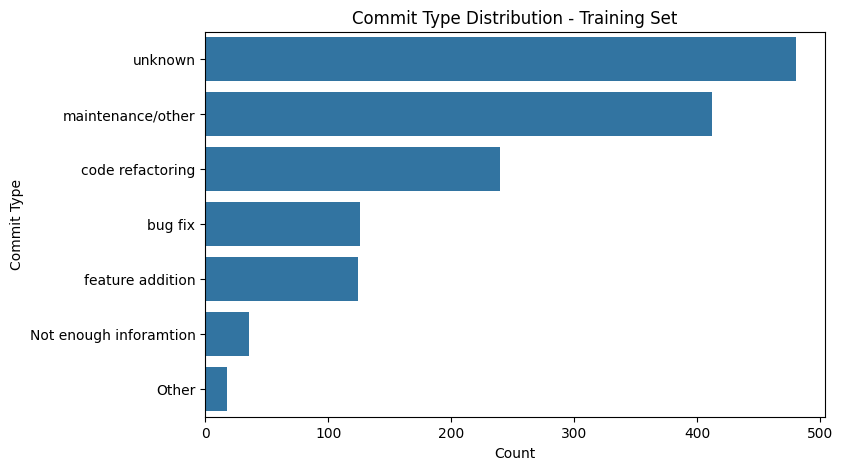

In [128]:
plt.figure(figsize=(8,5))
sns.countplot(y='Ground truth', data=train_df, order=train_df['Ground truth'].value_counts().index)
plt.title("Commit Type Distribution - Training Set")
plt.xlabel("Count")
plt.ylabel("Commit Type")
plt.show()

## Message length distribution

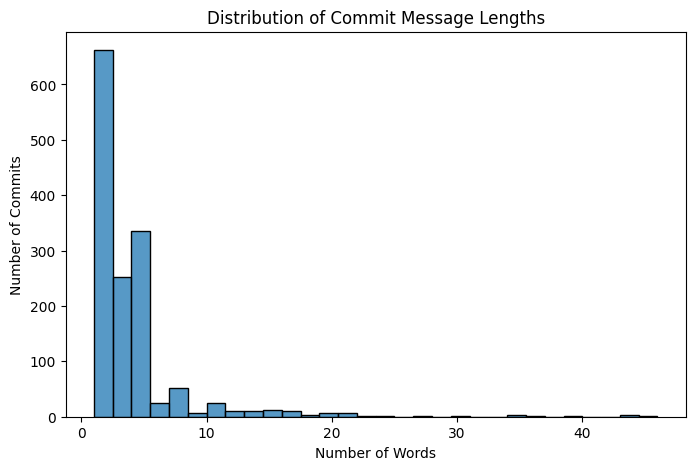

In [129]:
train_df['msg_len'] = train_df['clean_message'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,5))
sns.histplot(train_df, x='msg_len', bins=30)
plt.title("Distribution of Commit Message Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Commits")
plt.show()

## Text Vectorization: Transforming Cleaned Commit Messages into TF-IDF Features for Modeling
We transform the cleaned commit messages into numerical feature vectors using TF-IDF. This captures the importance of each word in a message while reducing the impact of common, less informative words. These numeric vectors can then be fed into machine learning models for commit type classification.

In [130]:
vectorizer = TfidfVectorizer(max_features=5000)

In [131]:
X_train_tfidf = vectorizer.fit_transform(train_df['clean_message'])
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4676 stored elements and shape (1436, 740)>

In [132]:
X_val_tfidf = vectorizer.transform(val_df['clean_message'])
X_val_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 818 stored elements and shape (306, 740)>

In [133]:
X_test_tfidf = vectorizer.transform(test_df['clean_message'])
X_test_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 475 stored elements and shape (206, 740)>

In [134]:
# Sample features from TF-IDF vectorizer
vectorizer.get_feature_names_out()[:20]

array(['aaron', 'ab', 'able', 'ac', 'access', 'accidentially', 'acme',
       'ad', 'adapt', 'add', 'added', 'adding', 'addition', 'additional',
       'adds', 'adduser', 'ae', 'aebbd', 'af', 'afda'], dtype=object)

In [135]:
y_train = train_df['Ground truth']
y_train

,Ground truth
0,maintenance/other
1,maintenance/other
2,maintenance/other
3,code refactoring
4,feature addition
...,...
1431,maintenance/other
1432,code refactoring
1433,code refactoring
1434,code refactoring


In [136]:
y_val = val_df['Ground truth']
y_val

,Ground truth
0,code refactoring
1,bug fix
2,maintenance/other
3,bug fix
4,code refactoring
...,...
301,maintenance/other
302,maintenance/other
303,feature addition
304,Other


In [137]:
y_test = test_df['Ground truth']
y_test

,Ground truth
0,unknown
1,unknown
2,unknown
3,unknown
4,unknown
...,...
201,bug fix
202,bug fix
203,code refactoring
204,Other


## Train Model

### Logistic Regression

In [138]:
log_model = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced'
)
log_model.fit(X_train_tfidf, y_train)
y_val_pred_log = log_model.predict(X_val_tfidf)
y_test_pred_log = log_model.predict(X_test_tfidf)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Naive Bayes

In [139]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_val_pred_nb = nb_model.predict(X_val_tfidf)
y_test_pred_nb = nb_model.predict(X_test_tfidf)

## Evaluate Model Performance

In [140]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Naive Bayes"],
    "Accuracy": [accuracy_score(y_test, y_test_pred_log), accuracy_score(y_test, y_test_pred_nb)],
    "F1-Score (macro)": [
        f1_score(y_test, y_test_pred_log, average='macro'),
        f1_score(y_test, y_test_pred_nb, average='macro')
    ]
})
results

,Model,Accuracy,F1-Score (macro)
0,Logistic Regression,0.514563,0.168412
1,Naive Bayes,0.703883,0.263467


## Classification Report

Logistic Regression Model

In [141]:
classification_report(y_test, y_test_pred_log)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

'                        precision    recall  f1-score   support\n\nNot enough inforamtion       0.00      0.00      0.00         0\n                 Other       0.00      0.00      0.00         7\n               bug fix       0.00      0.00      0.00        13\n      code refactoring       0.00      0.00      0.00        25\n      feature addition       0.13      1.00      0.24        14\n     maintenance/other       0.00      0.00      0.00        44\n               unknown       1.00      0.89      0.94       103\n\n              accuracy                           0.51       206\n             macro avg       0.16      0.27      0.17       206\n          weighted avg       0.51      0.51      0.49       206\n'

Naive Bayes Model

In [142]:
classification_report(y_test, y_test_pred_nb)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'                   precision    recall  f1-score   support\n\n            Other       0.00      0.00      0.00         7\n          bug fix       0.00      0.00      0.00        13\n code refactoring       0.00      0.00      0.00        25\n feature addition       0.00      0.00      0.00        14\nmaintenance/other       0.42      1.00      0.59        44\n          unknown       1.00      0.98      0.99       103\n\n         accuracy                           0.70       206\n        macro avg       0.24      0.33      0.26       206\n     weighted avg       0.59      0.70      0.62       206\n'

## Confusion Matrix

## Logistic Regression

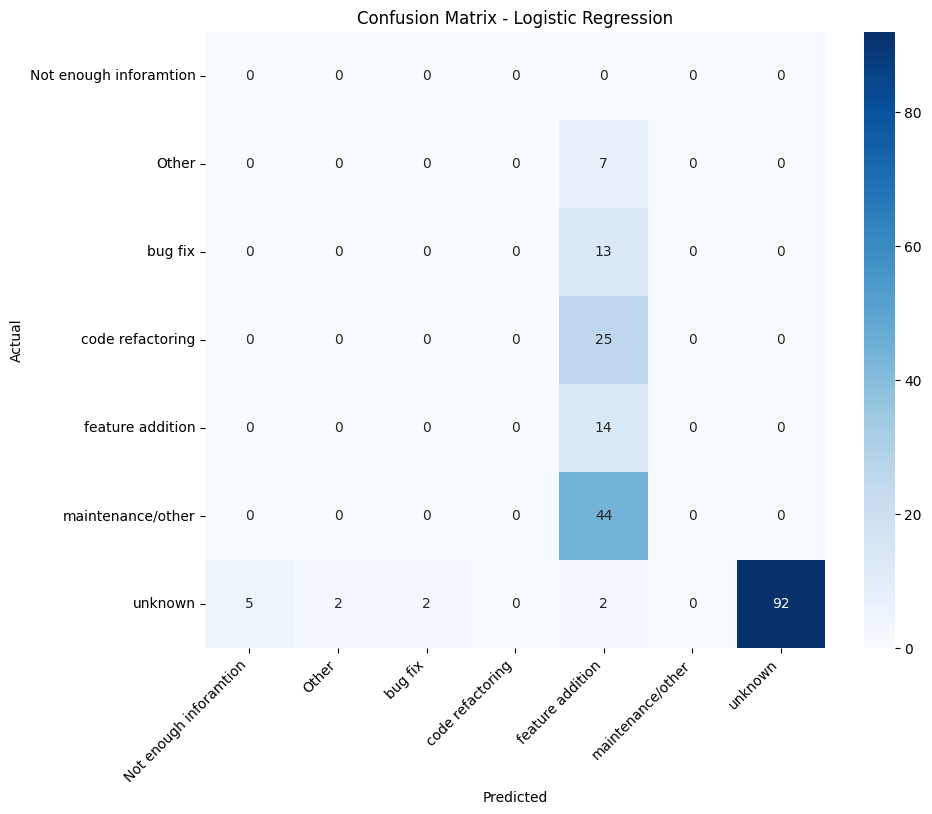

In [143]:
labels = sorted(train_df['Ground truth'].unique())  # consistent label order
cm_log = confusion_matrix(y_test, y_test_pred_log, labels=labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

## Naive Bayes

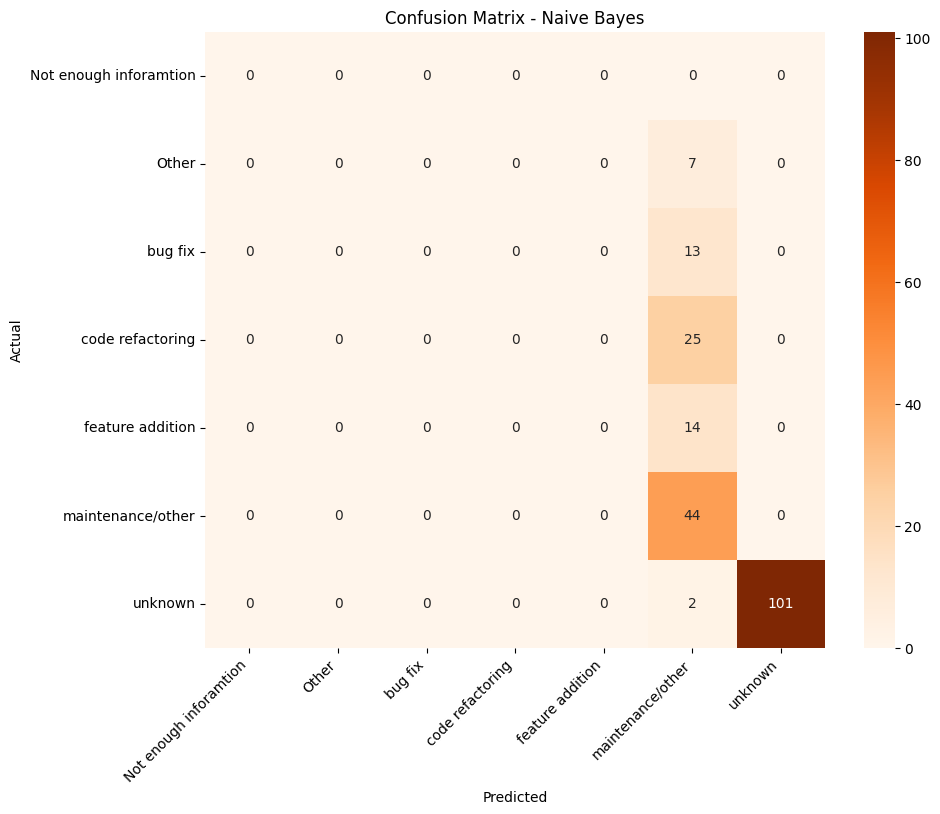

In [144]:
cm_nb = confusion_matrix(y_test, y_test_pred_nb, labels=labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


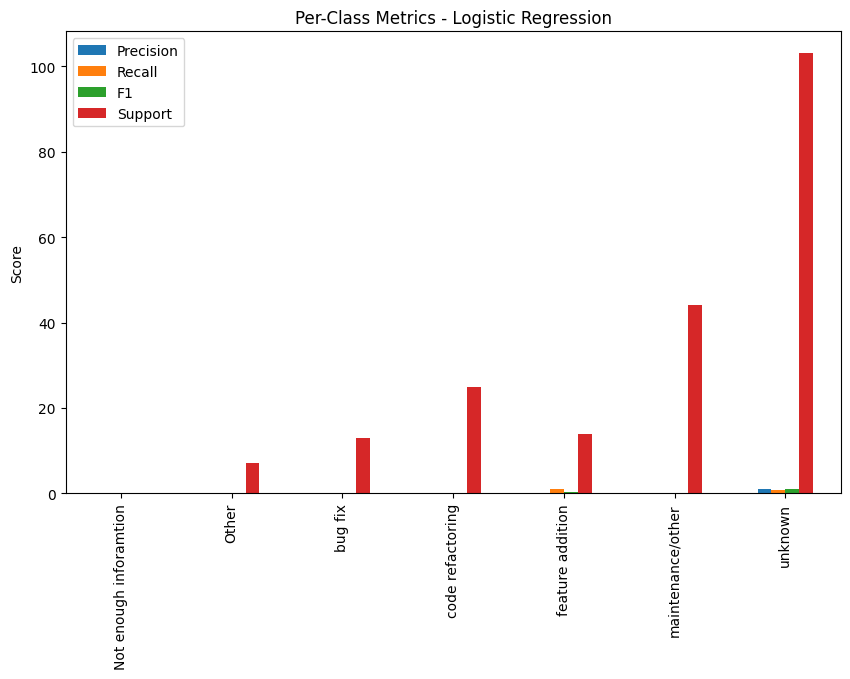

In [145]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred_log, labels=labels)
metrics_df = pd.DataFrame({"Precision": precision, "Recall": recall, "F1": f1, "Support": support}, index=labels)
metrics_df.plot(kind='bar', figsize=(10,6))
plt.title("Per-Class Metrics - Logistic Regression")
plt.ylabel("Score")
plt.show()

## Top words per commit type

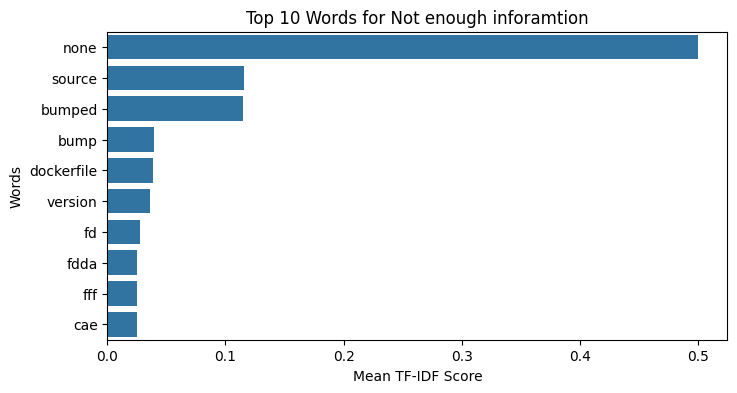

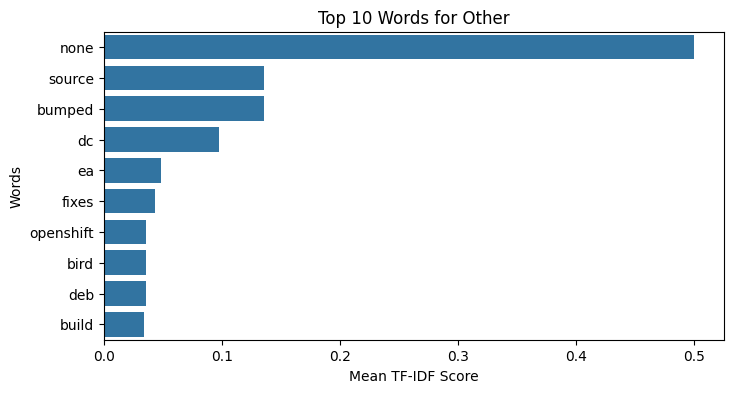

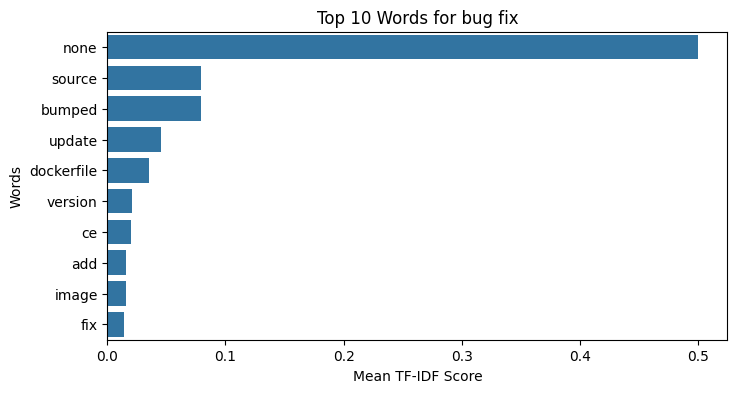

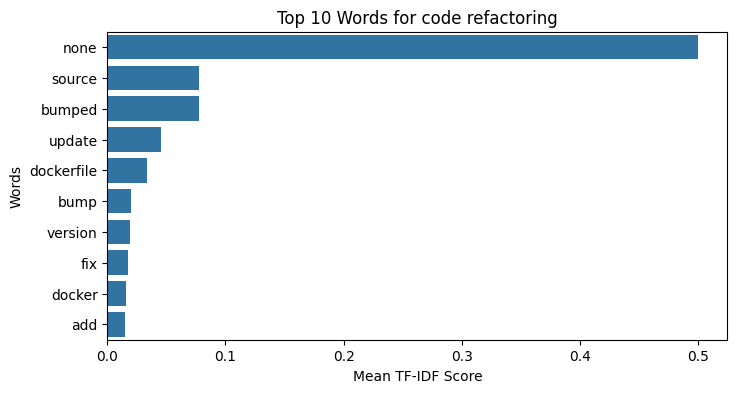

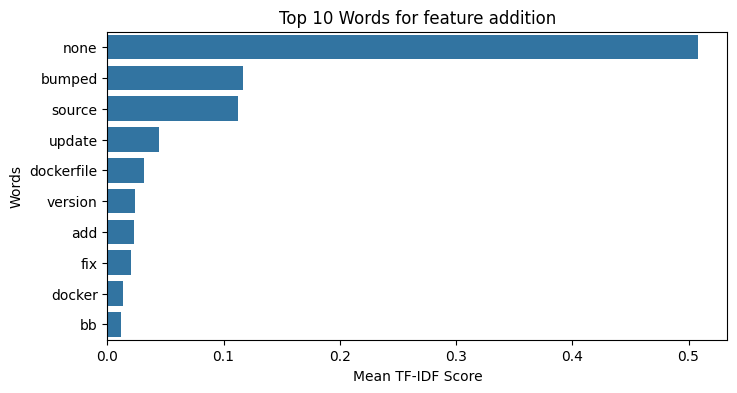

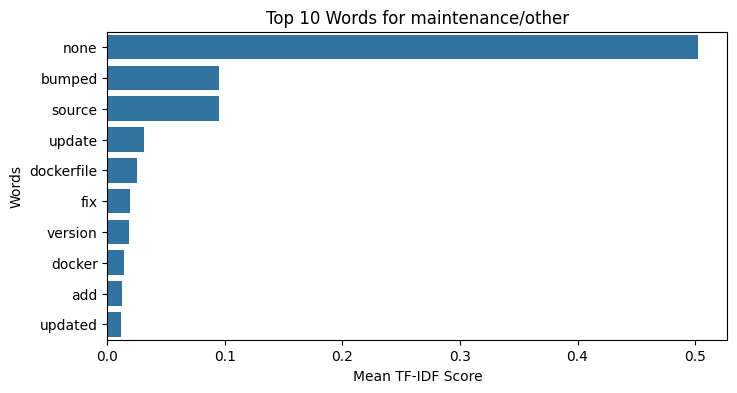

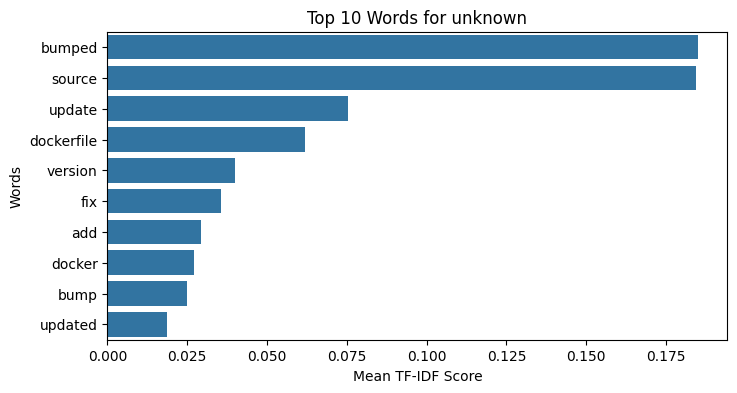

In [146]:
feature_names = vectorizer.get_feature_names_out()
top_n = 10

for label in labels:
    class_rows = train_df[train_df['Ground truth'] == label]['clean_message']
    if len(class_rows) == 0:
        continue
    class_tfidf = vectorizer.transform(class_rows)
    mean_tfidf = np.mean(class_tfidf.toarray(), axis=0)
    top_indices = mean_tfidf.argsort()[::-1][:top_n]
    top_words = [feature_names[i] for i in top_indices]
    top_scores = mean_tfidf[top_indices]

    plt.figure(figsize=(8,4))
    sns.barplot(x=top_scores, y=top_words)
    plt.title(f"Top {top_n} Words for {label}")
    plt.xlabel("Mean TF-IDF Score")
    plt.ylabel("Words")
    plt.show()

## Error Analysis

In [147]:
misclassified = test_df[y_test != y_test_pred_log].copy()
misclassified['pred'] = y_test_pred_log[y_test != y_test_pred_log]
print(misclassified[['Message', 'Ground truth', 'pred']].head(10))

                                              Message Ground truth  \
3                                     Bump to 5.6.2\n      unknown   
8             Bump Dockerfile to 9.1.0-498-8eb4171c\n      unknown   
17  fix docker build for the armebv7r-none-eabi ta...      unknown   
24                Bumped source to 20200505-fd84876\n      unknown   
35  docker: Fix the comments about settings.json c...      unknown   
41                Bumped source to 20200608-bb670e4\n      unknown   
44                                     Bump version\n      unknown   
48                              update dependencies\n      unknown   
66                   fixed Dockerfile to build site\n      unknown   
87  Adding build context for Openshift to Dockerfi...      unknown   

                      pred  
3   Not enough inforamtion  
8   Not enough inforamtion  
17        feature addition  
24  Not enough inforamtion  
35                 bug fix  
41        feature addition  
44  Not enough inforamtion